In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy import signal
import os
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error


setting = pd.read_csv('setting.csv', header = 0, usecols = [0,1])
DEMG_file = setting.iloc[0,1]
output_name = setting.iloc[2,1]
output_path = setting.iloc[1,1]

DEMGs = pd.read_csv(DEMG_file, header=14, )
time_DEMG = pd.read_csv(DEMG_file, header=14, usecols = [1])
# time_RMS = pd.read_csv(RMS_file, header=14, usecols = [1])

# file_name = "EMG"  + EMG_num + "-Filtered-Differentiated.csv" 
# data = pd.read_csv(file_name, header=1)
DEMGs.describe()


C:\Users\XPS\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,X [s],Trigno IM sensor 1: EMG 1 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 2: EMG 2 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 3: EMG 3 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 4: EMG 4 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 5: EMG 5 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 6: EMG 6 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 7: EMG 7 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 8: EMG 8 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 9: EMG 9 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 10: EMG 10 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 11: EMG 11 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 12: EMG 12 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 13: EMG 13 (IM)->Subset->Filter->Slope [Volts/s],Trigno IM sensor 14: EMG 14 (IM)->Subset->Filter->Slope [Volts/s]
count,323888.000000,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,323888.000000,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05,3.238880e+05
mean,145.749150,-3.669119e-08,-2.346878e-09,-1.900451e-08,9.457157e-09,7.123150e-08,-0.000005,-4.314344e-10,-9.136110e-08,-2.005401e-08,3.474875e-10,1.007240e-07,-3.940040e-08,-1.159584e-08,-3.453634e-08
std,84.148701,2.570481e-02,2.347028e-02,2.333285e-02,5.131289e-02,1.407643e-01,0.047087,3.646604e-02,2.986004e-02,2.166824e-02,2.544062e-02,2.931248e-02,2.375024e-02,4.156716e-02,3.514135e-02
min,0.000000,-7.881161e-01,-6.618641e-01,-3.525183e-01,-6.310702e-01,-2.126885e+00,-0.766218,-6.336994e-01,-5.264025e-01,-4.548493e-01,-4.267166e-01,-4.230905e-01,-3.375299e-01,-7.397474e-01,-5.212223e-01
25%,72.874575,-5.333912e-03,-5.198754e-03,-7.749604e-03,-1.249833e-02,-8.755239e-03,-0.006705,-1.041984e-02,-1.010415e-02,-5.788548e-03,-6.546252e-03,-8.779199e-03,-6.814356e-03,-1.235040e-02,-1.273592e-02
50%,145.749150,-4.126188e-05,-2.183133e-04,-1.255340e-04,-9.989600e-04,3.142203e-04,-0.000021,-6.191596e-04,2.225144e-04,2.354476e-04,2.830888e-04,-1.968143e-04,-2.400399e-04,-4.411210e-04,-1.875684e-04
75%,218.623725,5.345323e-03,4.751266e-03,7.324958e-03,7.873962e-03,9.994387e-03,0.006729,8.239295e-03,1.008135e-02,6.244974e-03,7.162370e-03,8.052236e-03,6.209082e-03,1.087541e-02,1.187847e-02
max,291.498300,5.250274e-01,5.133509e-01,2.880348e-01,8.620565e-01,2.349752e+00,0.860890,5.582092e-01,4.673996e-01,5.842412e-01,4.025866e-01,4.879756e-01,3.852590e-01,5.972859e-01,4.168027e-01


### Find AR Coefficients and Calculate the RMS value

In [2]:
# Define the RMS function
from math import sqrt
import statistics

def notch_filter(data, fs = 1111.1, f0 = 50, Q = 30):
    b, a = signal.iirnotch(f0, Q, fs)
    return sp.signal.filtfilt(b, a, data)
def get_max(data):
    return max(abs(data))
def get_normalized(data, max_data):
    return data/max_data
def get_AR_coeffs(data, num_coeff = 6):
    model = AR(data)
    model_fit = model.fit(maxlag = num_coeff, disp=False)
    return model_fit.params
def get_RMS(data):
    return sqrt(sum(n*n for n in data)/len(data))
def get_MAV(data):
    return sum(abs(n) for n in data)/len(data)
def remove_artifact(data):
    mean_value = statistics.mean(abs(data))
    print(mean_value)
    for i in range(len(data)):
        if abs(data[i]) > (mean_value*20):
            data[i] = data[i]/5
    return data

In [ ]:
step = 0.05
time_limit = max(DEMGs['X [s]'])
print(time_limit)
EMG_nums = 14
count_flag = False 
for EMG_num in range(EMG_nums):
    start = 0
    end = 0.1
    coeff = []
    count = 0
    time = []
    RMS = []
    MAV = []
    EMG_label = "Trigno IM sensor " + f'{EMG_num + 1}' + ": EMG " + f'{EMG_num + 1}' + " (IM)->Subset->Filter->Slope [Volts/s]"
    #Filter the data
    notch_filtered_DEMG_data = notch_filter(DEMGs[EMG_label])
    
    if (EMG_num == 12):
        filtered_DEMG_data = remove_artifact(notch_filtered_DEMG_data)
    else:
        filtered_DEMG_data = notch_filtered_DEMG_data
#     #Get max value
    max_DEMG = get_max(filtered_DEMG_data)
#     #Normalised data
    normalised_DEMG = get_normalized(filtered_DEMG_data,max_DEMG)
     
    while (end<time_limit):
        df = normalised_DEMG[(DEMGs['X [s]']>=start) & (DEMGs['X [s]'] < end)]
        DEMG_value = np.array(df[:])
        
        #Get the RMS
        DEMG_RMS_value = get_RMS(DEMG_value)
        
        #Get the MAV
        DEMG_MAV_value = get_MAV(DEMG_value)
        
        #Get the AR coefficients
        coef_temp = get_AR_coeffs(DEMG_value)

        start = start + step
        end = end + step
        if not count_flag:
            time.append(count*step)
            count = count + 1
        
        RMS.append(DEMG_RMS_value)
        MAV.append(DEMG_MAV_value)
        coeff.append(coef_temp)
        
    if not count_flag:
        time = np.array(time)
        dataset = pd.DataFrame({'Time': time})
        count_flag = True
        
    coeff = np.array(coeff)
    RMS = np.array(RMS)
    MAV = np.array(MAV)
    
    dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS, 'DEMG' + f'{EMG_num + 1}' + '_MAV': MAV})
#     dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
# 'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS})
    dataset = pd.concat([dataset,dataset_temp], axis = 1)
dataset.describe()

291.4983


In [3]:
step = 0.05
time_limit = max(DEMGs['X [s]'])
print(time_limit)
EMG_nums = 14
count_flag = False 
for EMG_num in range(EMG_nums):
    start = 0
    end = 0.1
    coeff = []
    count = 0
    time = []
    RMS = []
    MAV = []
    EMG_label = "Trigno IM sensor " + f'{EMG_num + 1}' + ": EMG " + f'{EMG_num + 1}' + " (IM)->Subset->Filter->Slope [Volts/s]"
    #Filter the data
    filtered_DEMG_data = notch_filter(DEMGs[EMG_label])
    #Get max value
    max_DEMG = get_max(filtered_DEMG_data)
    #Normalised data
    normalised_DEMG = get_normalized(filtered_DEMG_data,max_DEMG)
     
    while (end<time_limit):
        df = normalised_DEMG[(DEMGs['X [s]']>=start) & (DEMGs['X [s]'] < end)]
        DEMG_value = np.array(df[:])
        
        #Get the RMS
        DEMG_RMS_value = get_RMS(DEMG_value)
        
        #Get the MAV
        DEMG_MAV_value = get_MAV(DEMG_value)
        
        #Get the AR coefficients
        coef_temp = get_AR_coeffs(DEMG_value)

        start = start + step
        end = end + step
        if not count_flag:
            time.append(count*step)
            count = count + 1
        
        RMS.append(DEMG_RMS_value)
        MAV.append(DEMG_MAV_value)
        coeff.append(coef_temp)
        
    if not count_flag:
        time = np.array(time)
        dataset = pd.DataFrame({'Time': time})
        count_flag = True
        
    coeff = np.array(coeff)
    RMS = np.array(RMS)
    MAV = np.array(MAV)
    
    dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS, 'DEMG' + f'{EMG_num + 1}' + '_MAV': MAV})
#     dataset_temp =  pd.DataFrame({'DEMG' + f'{EMG_num + 1}' + '_AR1':coeff[:,1], 'DEMG' + f'{EMG_num + 1}' + '_AR2':coeff[:,2], 'DEMG' + f'{EMG_num + 1}' + '_AR3':coeff[:,3], \
# 'DEMG' + f'{EMG_num + 1}' + '_AR4':coeff[:,4], 'DEMG' + f'{EMG_num + 1}' + '_AR5':coeff[:,5], 'DEMG' + f'{EMG_num + 1}' + '_AR6':coeff[:,6], 'DEMG' + f'{EMG_num + 1}' + '_RMS': RMS})
    dataset = pd.concat([dataset,dataset_temp], axis = 1)
dataset.describe()

291.4983


,Time,DEMG1_AR1,DEMG1_AR2,DEMG1_AR3,DEMG1_AR4,DEMG1_AR5,DEMG1_AR6,DEMG1_RMS,DEMG1_MAV,DEMG2_AR1,...,DEMG13_RMS,DEMG13_MAV,DEMG14_AR1,DEMG14_AR2,DEMG14_AR3,DEMG14_AR4,DEMG14_AR5,DEMG14_AR6,DEMG14_RMS,DEMG14_MAV
count,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,...,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000,5828.000000
mean,145.675000,0.891512,-0.936979,0.765508,-0.757936,0.460684,-0.333252,0.018782,0.014270,0.773036,...,0.046123,0.032547,0.609864,-0.892743,0.679016,-0.690626,0.311019,-0.345980,0.058566,0.042083
std,84.127151,0.293920,0.261389,0.231371,0.186928,0.147002,0.086264,0.026849,0.020453,0.364196,...,0.033247,0.023193,0.305144,0.227527,0.193747,0.203342,0.162794,0.085715,0.034316,0.024022
min,0.000000,-0.088823,-1.997682,0.107494,-1.586285,0.016857,-0.875331,0.003841,0.002943,-0.194596,...,0.008349,0.006350,-0.162337,-1.722916,0.042614,-1.365021,-0.122430,-0.694323,0.013421,0.010281
25%,72.837500,0.672143,-1.108225,0.600924,-0.879093,0.356315,-0.391060,0.007070,0.005534,0.470578,...,0.014713,0.011533,0.377262,-1.055812,0.545929,-0.834715,0.185455,-0.402569,0.023670,0.018569
50%,145.675000,0.917895,-0.905849,0.737795,-0.750338,0.454108,-0.334339,0.011437,0.008744,0.785210,...,0.040767,0.027347,0.619922,-0.899208,0.656990,-0.710461,0.302467,-0.346739,0.055927,0.039328
75%,218.512500,1.112773,-0.735032,0.905813,-0.618233,0.560713,-0.274202,0.017176,0.012850,1.071188,...,0.067671,0.047216,0.835034,-0.706594,0.790084,-0.529672,0.425612,-0.292272,0.084473,0.059733
max,291.350000,1.742050,-0.313893,1.795815,-0.224324,1.042505,-0.044604,0.273382,0.217179,1.719636,...,0.202054,0.154965,1.516468,-0.287005,1.581511,-0.120894,0.897462,-0.037823,0.211822,0.140158


### Plot RMS graphs for each muscle of interest

In [4]:
label = ['Rectus Femoris','Bicep Femoris','Vastus Lateralis','Semitedinonius','Tibialis Anterior','Gastromedius','Soleus']
legends = ['Left','Right']
def plot(time, Y1, Y2, label):    
    plt.plot(time, Y1, 'r')
    plt.plot(time, Y2, 'b')
    plt.legend(legends, loc = 'upper right')
    plt.xlabel('Time [s]')
#     y_label = 'Volts/s'
#     plt.ylabel(y_label)
    plt.title(label)
#     plt.savefig('plots/' + label + '.pdf')
    plt.show()

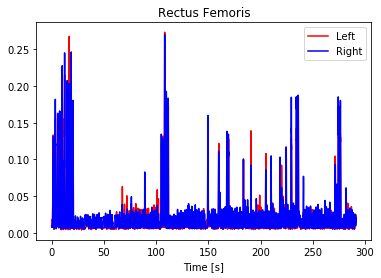

In [5]:
#Rectus Femoris
# plot(dataset.loc[1750:1800,'Time'],dataset.loc[1750:1800,'DEMG13_RMS'],dataset.loc[1750:1800,'DEMG14_RMS'], label[0])
plot(dataset['Time'],dataset['DEMG1_RMS'],dataset['DEMG2_RMS'], label[0])

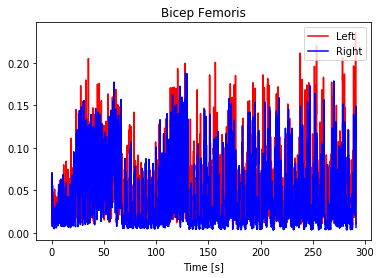

In [6]:
#Bicep Femoris
plot(dataset['Time'],dataset['DEMG3_RMS'],dataset['DEMG4_RMS'], label[1])

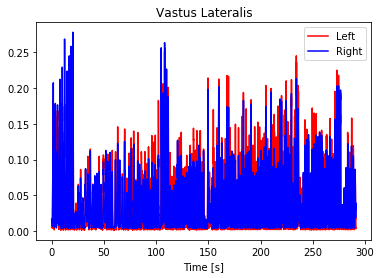

In [7]:
#Vastus Lateralis
# plot(dataset.loc[2080:2120,'Time'],dataset.loc[2080:2120,'DEMG6_RMS'],dataset.loc[2080:2120,'DEMG6_RMS'], label[0])
plot(dataset['Time'],dataset['DEMG5_RMS'],dataset['DEMG6_RMS'], label[2])

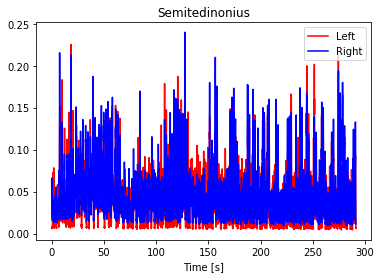

In [8]:
#Semitedinonius
plot(dataset['Time'],dataset['DEMG7_RMS'],dataset['DEMG8_RMS'], label[3])

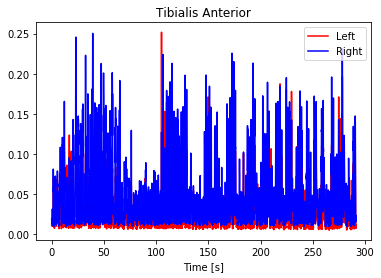

In [9]:
#Tibialis Anterior
plot(dataset['Time'],dataset['DEMG9_RMS'],dataset['DEMG10_RMS'], label[4])

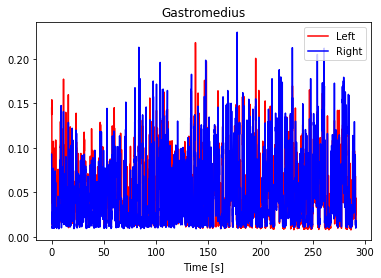

In [10]:
#Gastromedius
plot(dataset['Time'],dataset['DEMG11_RMS'],dataset['DEMG12_RMS'], label[5])

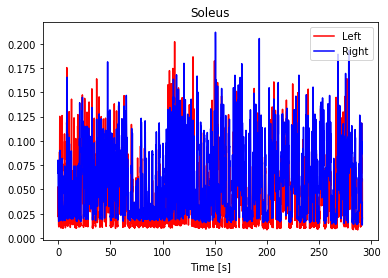

In [11]:
#Soleus
plot(dataset['Time'],dataset['DEMG13_RMS'],dataset['DEMG14_RMS'], label[6])


### Save the output

In [12]:
output_file = output_path + output_name + '.csv'
dataset.to_csv(output_file, index = False)